In [1]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd

import audio_functions as af
import model_functions as mf
import dataset
import librosa
import soundfile as sf
import tensorflow as tf
from keras import layers
from SegCaps import capsule_layers
from functools import partial
import datetime

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
Using TensorFlow backend.


In [2]:
#  Set some variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=4
normalise=True
batch_size = 5
shuffle=False
n_shuffle = 1

In [3]:
def get_paired_dataset(zipped_files,
                       sample_rate,
                       n_fft,
                       fft_hop,
                       patch_window,
                       patch_hop,
                       n_parallel_readers,
                       batch_size,
                       n_shuffle,
                       normalise):

    return (
        tf.data.Dataset.from_tensor_slices((zipped_files[:, 0], zipped_files[:, 1]))
        .map(partial(af.read_audio_pair,
                     sample_rate=sample_rate),
             num_parallel_calls=n_parallel_readers)
        .map(partial(af.extract_audio_patches_map,
                     fft_hop=fft_hop,
                     patch_window=patch_window,
                     patch_hop=patch_hop,),
             num_parallel_calls=n_parallel_readers)
        .flat_map(af.zip_tensor_slices)
        .map(partial(compute_spectrogram_map,
                     n_fft=n_fft,
                     fft_hop=fft_hop,
                     normalise=normalise),
             num_parallel_calls=n_parallel_readers)
        .shuffle(n_shuffle).batch(batch_size).prefetch(3)
    )

def compute_spectrogram_map(audio_a, audio_b, n_fft, fft_hop, normalise=False):
    spec_a = compute_spectrogram(audio_a, n_fft, fft_hop, normalise, mag_phase=False)
    spec_b = compute_spectrogram(audio_b, n_fft, fft_hop, normalise, mag_phase=False)

    return spec_a, spec_b, audio_a, audio_b

def compute_spectrogram(audio, n_fft, fft_hop, normalise=False, mag_phase=True):
    '''
    Parameters
    ----------
    audio : single to dual channel audio shaped (n_samples, )

    Returns
    -------
    Tensor of shape (n_frames, 1 + n_fft / 2, 2), where the last dimension is (magnitude, phase)
    '''

    def stft(x, normalise, mag_phase):
        spec = librosa.stft(
            x, n_fft=n_fft, hop_length=fft_hop, window='hann')
        
        if mag_phase:
            mag = np.abs(spec)
            if normalise:
                # TODO: normalize?
                mag = (mag - mag.min()) / (mag.max() - mag.min())
            return mag, np.angle(spec)
        else:
            return spec.real, spec.imag

    def mono_func(py_audio, normalise, mag_phase):
        mag, phase = stft(py_audio[:, 0], normalise, mag_phase)
        ret = np.array([mag, phase]).T
        return ret.astype(np.float32)

    with tf.name_scope('read_spectrogram'):
        ret = tf.py_func(mono_func, [audio, normalise, mag_phase], tf.float32, stateful=False)
        ret.set_shape([(audio.get_shape()[0].value/fft_hop) + 1, 1 + n_fft / 2, 2])
    return ret


In [108]:
channels.shape

(2, 513, 753)

In [11]:
directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Voice/train-clean-100/19/198/'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Mixed/train-clean-100/19/198/'

#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b)
data = get_paired_dataset(data,
                          sample_rate,
                          n_fft,
                          fft_hop,
                          patch_window,
                          patch_hop,
                          n_parallel_readers,
                          batch_size,
                          n_shuffle,
                          normalise)

#  Create the iterator
pipe = data.make_initializable_iterator()
mixed_spec, voice_spec, mixed_audio, voice_audio = pipe.get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_spec_trim = mixed_spec[:, :, :-1, :]
voice_spec_trim = voice_spec[:, :, :-1, :]

In [12]:
data

<PrefetchDataset shapes: ((?, 256, 513, 2), (?, 256, 513, 2), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

In [13]:
mixed_spec_trim.shape

TensorShape([Dimension(None), Dimension(256), Dimension(512), Dimension(2)])

In [14]:
class ComplexNumberCapsNet(object):
    
    def __init__(self, mixed_spec, voice_spec, is_training, reuse=True, name='complex_number_capsnet'):
        """
        input_tensor: Tensor with shape [batch_size, height, width, 2], where the two channels are the real 
                      and imaginary parts of the spectrogram
        is_training:  Boolean - should the model be trained on the current input or not
        name:         Model instance name
        """
        with tf.variable_scope(name):
            self.mixed_spec = mixed_spec
            self.voice_spec = voice_spec
            
            with tf.variable_scope('Primary_Caps'):
                
                # Reshape layer to be 1 capsule x [filters] atoms
                _, H, W, C = mixed_spec.get_shape()
                input_caps = layers.Reshape((H.value, W.value, 1, C.value))(mixed_spec)
                self.input_caps = input_caps
            
            with tf.variable_scope('Conv_Caps'):
                conv_caps = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=2, strides=1, padding='same',
                                                               routings=1, name='primarycaps')(input_caps)
                self.conv_caps = conv_caps
                
#            with tf.variable_scope('Seg_Caps'):
#                seg_caps = capsule_layers.ConvCapsuleLayer(kernel_size=1, num_capsule=16, num_atoms=2, strides=1, padding='same',
#                                                           routings=3, name='seg_caps')(conv_caps)
#                self.seg_caps = seg_caps
            
            with tf.variable_scope('Reconstruction'):
                reconstruction = capsule_layers.ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=2, strides=1, padding='same',
                                                           routings=3, name='seg_caps')(conv_caps)
                reconstruction = layers.Reshape((H.value, W.value, C.value))(reconstruction)
                self.reconstruction = reconstruction
            
            self.cost = mf.l1_loss(self.reconstruction, voice_spec)

            self.optimizer = tf.train.AdamOptimizer(
                learning_rate=0.0002,
                beta1=0.5,
            )
            self.train_op = self.optimizer.minimize(self.cost)

In [15]:
model = ComplexNumberCapsNet(mixed_spec_trim, voice_spec_trim, is_training=True)

In [16]:
print('Layers\' Shapes:\n'
      '\nInput: ', mixed_spec.get_shape().as_list(),
      '\nPrimary Caps: ',model.input_caps.get_shape().as_list(),
      '\nConv Caps: ',model.conv_caps.get_shape().as_list(),
     # '\nSeg Caps: ',model.seg_caps.get_shape().as_list(),
      '\nRecontruction: ',model.reconstruction.get_shape().as_list()
     )

Layers' Shapes:

Input:  [None, 256, 513, 2] 
Primary Caps:  [None, 256, 512, 1, 2] 
Conv Caps:  [None, 256, 512, 8, 2] 
Recontruction:  [None, 256, 512, 2]


In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
print('start: {}'.format(datetime.datetime.now()))
for i in range(5):
    _, mix, voice, est, cost = sess.run([model.train_op, tf.complex(model.mixed_spec[:,:,:,0], model.mixed_spec[:,:,:,1]), 
                                         tf.complex(model.voice_spec[:,:,:,0], model.voice_spec[:,:,:,1]),
                                         tf.complex(model.reconstruction[:,:,:,0], model.reconstruction[:,:,:,0]), 
                                         model.cost])
    
    print('Iteration {i}: {dt}\nCost: {c}'.format(i=i, dt=datetime.datetime.now(), c=cost))

In [23]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(pipe.initializer)
print('start: {}'.format(datetime.datetime.now()))
epochs = 200
epoch = 0
i = 0
while epoch < epochs:
    try:
        _, mix, voice, est, cost = sess.run([model.train_op, tf.complex(model.mixed_spec[:,:,:,0], model.mixed_spec[:,:,:,1]), 
                                             tf.complex(model.voice_spec[:,:,:,0], model.voice_spec[:,:,:,1]),
                                             tf.complex(model.reconstruction[:,:,:,0], model.reconstruction[:,:,:,0]), 
                                             model.cost])

        #print('Iteration {i}: {dt}\nCost: {c}'.format(i=i, dt=datetime.datetime.now(), c=cost))
        i += 1
    except tf.errors.OutOfRangeError:
        print('Epoch {e} finished.'.format(e=epoch))
        epoch += 1
        sess.run(pipe.initializer)
        

start: 2018-09-27 11:25:30.640688
Epoch 0 finished.
Epoch 1 finished.
Epoch 2 finished.
Epoch 3 finished.
Epoch 4 finished.
Epoch 5 finished.
Epoch 6 finished.
Epoch 7 finished.
Epoch 8 finished.
Epoch 9 finished.
Epoch 10 finished.
Epoch 11 finished.
Epoch 12 finished.
Epoch 13 finished.
Epoch 14 finished.
Epoch 15 finished.
Epoch 16 finished.
Epoch 17 finished.
Epoch 18 finished.
Epoch 19 finished.
Epoch 20 finished.
Epoch 21 finished.
Epoch 22 finished.
Epoch 23 finished.
Epoch 24 finished.
Epoch 25 finished.
Epoch 26 finished.
Epoch 27 finished.
Epoch 28 finished.
Epoch 29 finished.
Epoch 30 finished.
Epoch 31 finished.
Epoch 32 finished.
Epoch 33 finished.
Epoch 34 finished.
Epoch 35 finished.
Epoch 36 finished.
Epoch 37 finished.
Epoch 38 finished.
Epoch 39 finished.
Epoch 40 finished.
Epoch 41 finished.
Epoch 42 finished.
Epoch 43 finished.
Epoch 44 finished.
Epoch 45 finished.
Epoch 46 finished.
Epoch 47 finished.
Epoch 48 finished.
Epoch 49 finished.
Epoch 50 finished.
Epoch 5

ResourceExhaustedError: OOM when allocating tensor with shape[5,8,256,512,1,2]
	 [[Node: complex_number_capsnet/gradients/complex_number_capsnet/Reconstruction/seg_caps/while/mul_3_grad/mul_1 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](complex_number_capsnet/gradients/complex_number_capsnet/Reconstruction/seg_caps/while/mul_3_grad/mul_1/Enter, complex_number_capsnet/gradients/complex_number_capsnet/Reconstruction/seg_caps/while/Sum_1_grad/Tile)]]

Caused by op 'complex_number_capsnet/gradients/complex_number_capsnet/Reconstruction/seg_caps/while/mul_3_grad/mul_1', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-012e1ee248ed>", line 1, in <module>
    model = ComplexNumberCapsNet(mixed_spec_trim, voice_spec_trim, is_training=True)
  File "<ipython-input-14-34106e1c276e>", line 43, in __init__
    self.train_op = self.optimizer.minimize(self.cost)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 343, in minimize
    grad_loss=grad_loss)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 414, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 581, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 353, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 581, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py", line 747, in _MulGrad
    array_ops.reshape(math_ops.reduce_sum(x * grad, ry), sy))
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 894, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 1117, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2726, in _mul
    "Mul", x=x, y=y, name=name)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'complex_number_capsnet/Reconstruction/seg_caps/while/mul_3', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
[elided 19 identical lines from previous traceback]
  File "<ipython-input-15-012e1ee248ed>", line 1, in <module>
    model = ComplexNumberCapsNet(mixed_spec_trim, voice_spec_trim, is_training=True)
  File "<ipython-input-14-34106e1c276e>", line 33, in __init__
    routings=3, name='seg_caps')(conv_caps)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/keras/engine/base_layer.py", line 457, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/enterprise.internal.city.ac.uk/acvn728/MScFinalProject/SegCaps/capsule_layers.py", line 154, in call
    num_routing=self.routings)
  File "/home/enterprise.internal.city.ac.uk/acvn728/MScFinalProject/SegCaps/capsule_layers.py", line 345, in update_routing
    swap_memory=True)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2816, in while_loop
    result = loop_context.BuildLoop(cond, body, loop_vars, shape_invariants)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2640, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2590, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "/home/enterprise.internal.city.ac.uk/acvn728/MScFinalProject/SegCaps/capsule_layers.py", line 332, in _body
    distances = tf.reduce_sum(votes * act_replicated, axis=-1)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 894, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 1117, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2726, in _mul
    "Mul", x=x, y=y, name=name)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[5,8,256,512,1,2]
	 [[Node: complex_number_capsnet/gradients/complex_number_capsnet/Reconstruction/seg_caps/while/mul_3_grad/mul_1 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](complex_number_capsnet/gradients/complex_number_capsnet/Reconstruction/seg_caps/while/mul_3_grad/mul_1/Enter, complex_number_capsnet/gradients/complex_number_capsnet/Reconstruction/seg_caps/while/Sum_1_grad/Tile)]]


In [24]:
voice_est_wave = list()
voice_wave = list()
mix_wave = list()


for i in range(est.shape[0]):
    voice_est_wave.append(librosa.istft(est[i, :, :].T, fft_hop))

for i in range(voice.shape[0]):
    voice_wave.append(librosa.istft(voice[i, :, :].T, fft_hop))
    
for i in range(mix.shape[0]):
    mix_wave.append(librosa.istft(mix[i, :, :].T, fft_hop))

In [35]:
ipd.Audio(voice_est_wave[0].T, rate=sample_rate)

In [34]:
ipd.Audio(voice_wave[3].T, rate=sample_rate)

In [33]:
ipd.Audio(mix_wave[4], rate=sample_rate)

In [22]:
ipd.Audio(voice_est_wave[0].T, rate=sample_rate)

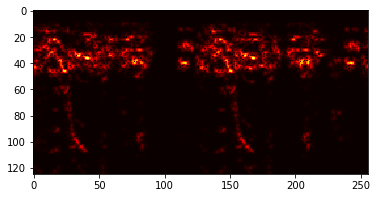

In [37]:
spec = librosa.stft(voice_est_wave[0], n_fft=n_fft, hop_length=fft_hop, window='hann')
mag = np.abs(spec)
plt.imshow(mag[:125,:])